Работу выполнили студенты 2 курса Высшей Школы ИТИС группы 11-803, Артемьев Артем и Арсембекова Талия

**Контекст:** Супермаркет предлагает новую линейку органических продуктов. Руководство супермаркета хочет определить, какие клиенты, скорее всего, купят эти продукты.

**Описание:** В супермаркете действует программа лояльности клиентов. В качестве плана для первоначального стимулирования покупок всем участникам программы лояльности были предложены купоны на покупку органических продуктов. Затем были собраны данные о том, купили ли эти клиенты какой-либо из органических продуктов.

**Цель:** Исследовать модель для предсказания влияний купонов на покупку товара.

In [31]:

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pydot
import numpy as np

from sklearn.tree import export_graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, r2_score

In [32]:
data = pd.read_csv('C:/Users/One/Downloads/Dataset/dataframe_ORGANICS/ORGANICS.csv', delimiter=',')
data.head()

,ID,DemAffl,DemAge,DemCluster,DemClusterGroup,DemGender,DemReg,DemTVReg,PromClass,PromSpend,PromTime,TargetBuy,TargetAmt
0,140,10.0,76.0,16.0,C,U,Midlands,Wales & West,Gold,16000.00,4.0,0,0
1,620,4.0,49.0,35.0,D,U,Midlands,Wales & West,Gold,6000.00,5.0,0,0
2,868,5.0,70.0,27.0,D,F,Midlands,Wales & West,Silver,0.02,8.0,1,1
3,1120,10.0,65.0,51.0,F,M,Midlands,Midlands,Tin,0.01,7.0,1,1
4,2313,11.0,68.0,4.0,A,F,Midlands,Midlands,Tin,0.01,8.0,0,0


**Описание датасета:**

**ID** - ид клиента-участника программы лояльности 

**DemAffl** - уровень дохода клиента (от 1 до 30) 

**DemAge** - возраст клиента

**DemCluster** - тип района, в котором живет клиент 

**DemClusterGroup** - область проживания 

**DemGender** - M = мужской, F = женский, U = неопределенный 

**DemReg** - географический район 

**DemTVReg** - регион телевещания 

**PromClass** - Статус программы лояльности: tin - оловянный, silver - серебряный, gold - золотой, platinum - платинум 

**PromSpend** - общая потраченная сумма 

**PromTime** - срок участия в программе лояльности 

**TargetBuy** - был ли приобретен ли продукт: 0 = Нет, 1 = Да 

**TargetAmt** - количество приобритенных продуктов

In [33]:
print(data.shape)

(22223, 13)


Заметим, что DemGender(пол человека) имеет значени U(неопределенный). Мы думаем, что стоит заменить его на наиболее часто встречаемое значение, тк пол человека, который купил товар, может оказать влияние на результат.

In [34]:
i = 0
for x in data['DemGender']:
    if x == 'U':
        data.iloc[i, data.columns.get_loc('DemGender')] = np.NaN
    i = i + 1

Мы видим, что у нас есть NaN значения. Замени их на средние 

In [35]:
data = data.fillna(data.mode().iloc[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22223 entries, 0 to 22222
Data columns (total 13 columns):
ID                 22223 non-null int64
DemAffl            22223 non-null float64
DemAge             22223 non-null float64
DemCluster         22223 non-null float64
DemClusterGroup    22223 non-null object
DemGender          22223 non-null object
DemReg             22223 non-null object
DemTVReg           22223 non-null object
PromClass          22223 non-null object
PromSpend          22223 non-null float64
PromTime           22223 non-null float64
TargetBuy          22223 non-null int64
TargetAmt          22223 non-null int64
dtypes: float64(5), int64(3), object(5)
memory usage: 2.2+ MB


Проведем одномерный анализ (Анализ каждого признака независимо от других)

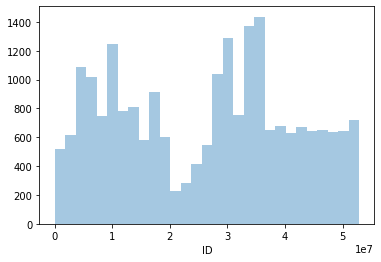

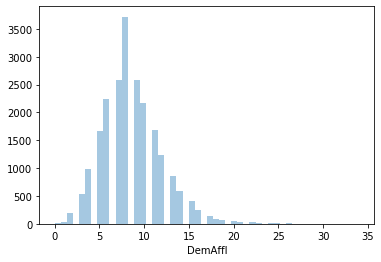

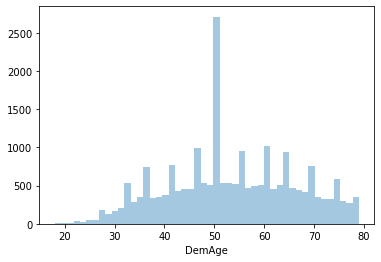

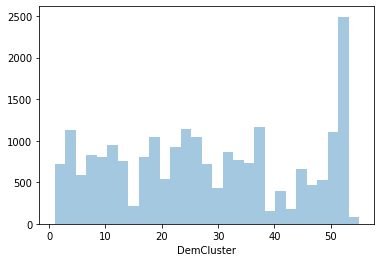

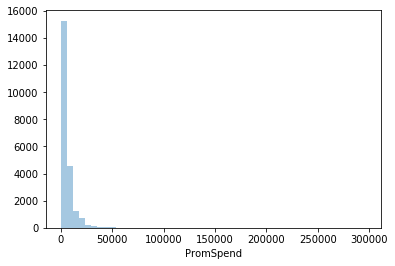

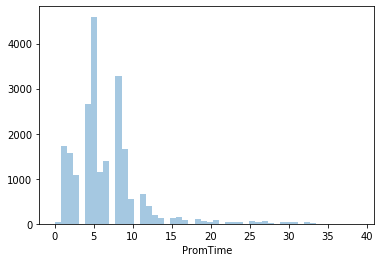

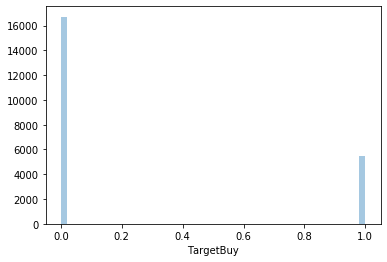

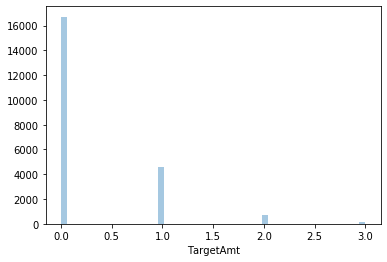

In [36]:
for i in data.var().index:
    sns.distplot(data[i],kde=False)
    plt.show()

Так же можно удалить столбец TargetAmt, так как количество приобритенных продуктов не потребуется нам дальше для анализа

In [37]:
data = data.drop(columns=['TargetAmt'])

Удалим стобец Id, так как ид клиента не понадобится на в будущем 

In [38]:
data = data.drop(columns=['ID'])

Проведем Бивариантный анализ Корреляция – связь между двумя метрическими переменными. При построении корреляции, мы ищем признаки, зависимые друг от друга или каким-либо образом влияющие на значения друг друга. Коэффициент корреляции признака с самим собой всегда равен единице, это значение не должно учитываться при исследовании зависимостей. Удобное представление коэффициентов корреляции - тепловая карта, представленная ниже:

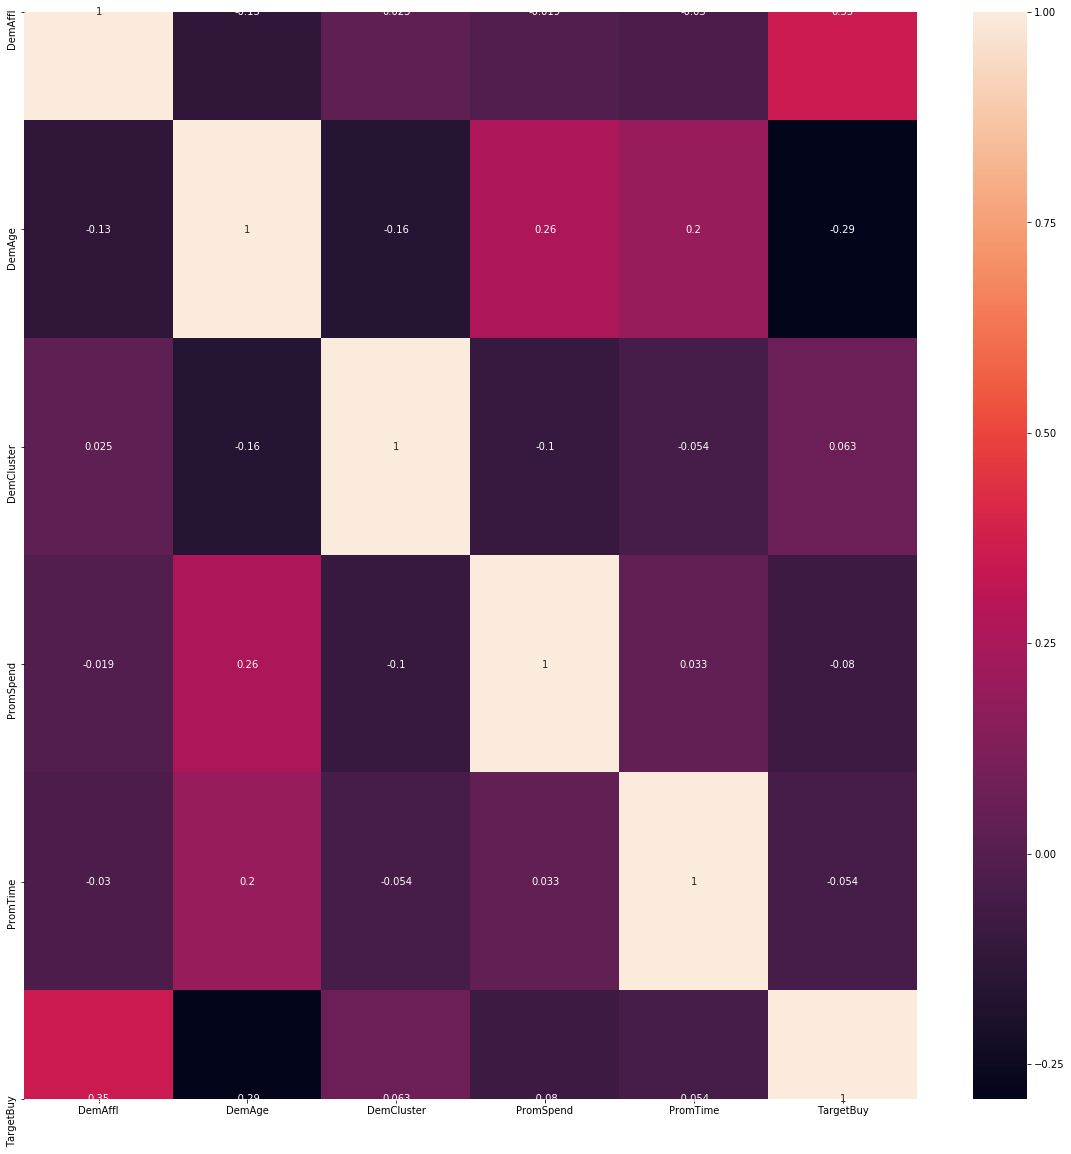

In [39]:
plt.figure(figsize=(20, 20))
correlation_matrix = data.corr()  
sns.heatmap(correlation_matrix, annot=True)
plt.show()

Посмотрим, какие факторы больше всего влеяют на TargetBuy(был ли куплен товар)

In [40]:
c_target = abs(correlation_matrix['TargetBuy'])
rf = c_target[c_target >= 0.2].drop('TargetBuy')
print(rf)

DemAffl    0.349522
DemAge     0.291768
Name: TargetBuy, dtype: float64


**Проведя анализ, мы видим, что DemAffl - уровень дохода клиента (от 1 до 30), DemAge - возраст клиента больше всего влияют на покупку новой линейки органических продуктов.**

Проверия, какая группы людей, в плане дохода, больше всего купила товар

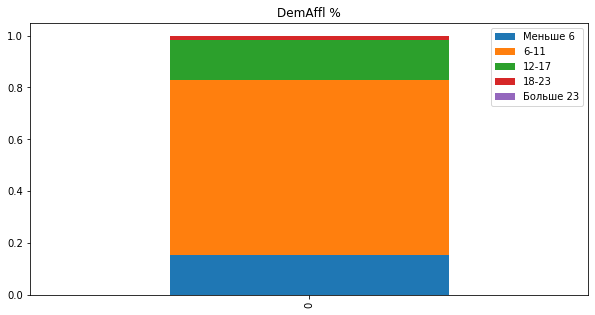

,Меньше 6,6-11,12-17,18-23,Больше 23
Affl group,0.153625,0.673761,0.156775,0.013365,0.00207


In [41]:
data2 = data
data2['Affl group'] = pd.cut(data2['DemAffl'], [0,5,11,17,23,30], labels=['Меньше 6', '6-11', '12-17', '18-23', 'Больше 23'])

temp_list = [x for x in data2['Affl group'] if x == 'Меньше 6']
GP1 = len(temp_list)/len(data2)
temp_list = [x for x in data2['Affl group'] if x == '6-11']
GP2 = len(temp_list)/len(data2)
temp_list = [x for x in data2['Affl group'] if x == '12-17']
GP3 = len(temp_list)/len(data2)
temp_list = [x for x in data2['Affl group'] if x == '18-23']
GP4 = len(temp_list)/len(data2)
temp_list = [x for x in data2['Affl group'] if x == 'Больше 23']
GP5 = len(temp_list)/len(data2)

dataForInpt = {'Меньше 6': [GP1], '6-11': [GP2], '12-17':[GP3], '18-23':[GP4], 'Больше 23':[GP5]}
data3 = pd.DataFrame.from_dict(dataForInpt)

data3.plot.bar(stacked=True, title ='DemAffl %',figsize=(10,5))
plt.show()
plt.close()

data3.rename(index={0: 'Affl group'})

**Как мы видим, люди, с доходом 6-11, больше всех купили товар.** 
Проделаем тоже самое с категорией по возрасту

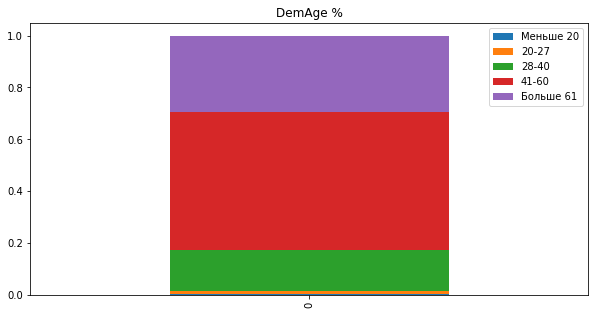

,Меньше 20,20-27,28-40,41-60,Больше 61
Age group,0.000675,0.011205,0.160554,0.534446,0.29312


In [42]:
data2['Age group'] = pd.cut(data2['DemAge'], [0,19,27,40,61,110], labels=['Меньше 20', '20-27', '28-40', '41-60', 'Больше 61'])

temp_list = [x for x in data2['Age group'] if x == 'Меньше 20']
GP1 = len(temp_list)/len(data2)
temp_list = [x for x in data2['Age group'] if x == '20-27']
GP2 = len(temp_list)/len(data2)
temp_list = [x for x in data2['Age group'] if x == '28-40']
GP3 = len(temp_list)/len(data2)
temp_list = [x for x in data2['Age group'] if x == '41-60']
GP4 = len(temp_list)/len(data2)
temp_list = [x for x in data2['Age group'] if x == 'Больше 61']
GP5 = len(temp_list)/len(data2)

dataForInpt = {'Меньше 20': [GP1], '20-27': [GP2], '28-40':[GP3], '41-60':[GP4], 'Больше 61':[GP5]}
data3 = pd.DataFrame.from_dict(dataForInpt)

data3.plot.bar(stacked=True, title ='DemAge %',figsize=(10,5))
plt.show()
plt.close()

data3.rename(index={0: 'Age group'})

**Как мы видим, люди в возрасте от 41 до 60 лет больше всего купили товар**

Также стоит проверить, кто чаще покупаем товар, мужчины или женщины.

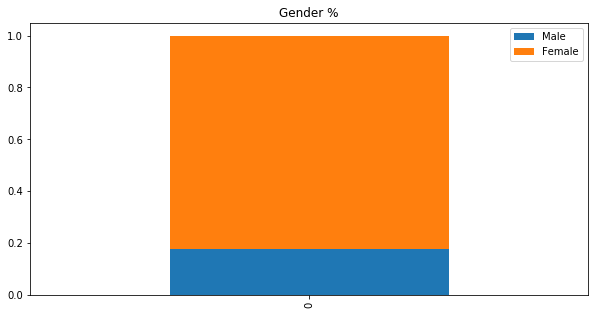

,Male,Female
Gender,0.175477,0.824523


In [43]:
data4 = data2[data2['TargetBuy']==1]

temp_list = [x for x in data4['DemGender'] if x == 'M']
M = len(temp_list)/len(data4)
temp_list = [x for x in data4['DemGender'] if x == 'F']
F = len(temp_list)/len(data4)

dataForInpt = {'Male': [M], 'Female': [F]}
data3 = pd.DataFrame.from_dict(dataForInpt)

data3.plot.bar(stacked=True, title ='Gender %',figsize=(10,5))
plt.show()
plt.close()

data3.rename(index={0: 'Gender'})

In [44]:
data.head()

,DemAffl,DemAge,DemCluster,DemClusterGroup,DemGender,DemReg,DemTVReg,PromClass,PromSpend,PromTime,TargetBuy,Affl group,Age group
0,10.0,76.0,16.0,C,F,Midlands,Wales & West,Gold,16000.00,4.0,0,6-11,Больше 61
1,4.0,49.0,35.0,D,F,Midlands,Wales & West,Gold,6000.00,5.0,0,Меньше 6,41-60
2,5.0,70.0,27.0,D,F,Midlands,Wales & West,Silver,0.02,8.0,1,Меньше 6,Больше 61
3,10.0,65.0,51.0,F,M,Midlands,Midlands,Tin,0.01,7.0,1,6-11,Больше 61
4,11.0,68.0,4.0,A,F,Midlands,Midlands,Tin,0.01,8.0,0,6-11,Больше 61


In [45]:
data.dtypes

DemAffl             float64
DemAge              float64
DemCluster          float64
DemClusterGroup      object
DemGender            object
DemReg               object
DemTVReg             object
PromClass            object
PromSpend           float64
PromTime            float64
TargetBuy             int64
Affl group         category
Age group          category
dtype: object

In [46]:
#Преобразуем категориальные данные
data4 = pd.get_dummies(data=data, columns=['DemClusterGroup', 'DemGender', 'DemReg', 'DemTVReg', 'PromClass'])

In [47]:
data4.head()

,DemAffl,DemAge,DemCluster,PromSpend,PromTime,TargetBuy,Affl group,Age group,DemClusterGroup_A,DemClusterGroup_B,...,DemTVReg_N West,DemTVReg_S & S East,DemTVReg_S West,DemTVReg_Ulster,DemTVReg_Wales & West,DemTVReg_Yorkshire,PromClass_Gold,PromClass_Platinum,PromClass_Silver,PromClass_Tin
0,10.0,76.0,16.0,16000.00,4.0,0,6-11,Больше 61,0,0,...,0,0,0,0,1,0,1,0,0,0
1,4.0,49.0,35.0,6000.00,5.0,0,Меньше 6,41-60,0,0,...,0,0,0,0,1,0,1,0,0,0
2,5.0,70.0,27.0,0.02,8.0,1,Меньше 6,Больше 61,0,0,...,0,0,0,0,1,0,0,0,1,0
3,10.0,65.0,51.0,0.01,7.0,1,6-11,Больше 61,0,0,...,0,0,0,0,0,0,0,0,0,1
4,11.0,68.0,4.0,0.01,8.0,0,6-11,Больше 61,1,0,...,0,0,0,0,0,0,0,0,0,1


In [48]:
data4.columns

Index(['DemAffl', 'DemAge', 'DemCluster', 'PromSpend', 'PromTime', 'TargetBuy',
       'Affl group', 'Age group', 'DemClusterGroup_A', 'DemClusterGroup_B',
       'DemClusterGroup_C', 'DemClusterGroup_D', 'DemClusterGroup_E',
       'DemClusterGroup_F', 'DemClusterGroup_U', 'DemGender_F', 'DemGender_M',
       'DemReg_Midlands', 'DemReg_North', 'DemReg_Scottish',
       'DemReg_South East', 'DemReg_South West', 'DemTVReg_Border',
       'DemTVReg_C Scotland', 'DemTVReg_East', 'DemTVReg_London',
       'DemTVReg_Midlands', 'DemTVReg_N East', 'DemTVReg_N Scot',
       'DemTVReg_N West', 'DemTVReg_S & S East', 'DemTVReg_S West',
       'DemTVReg_Ulster', 'DemTVReg_Wales & West', 'DemTVReg_Yorkshire',
       'PromClass_Gold', 'PromClass_Platinum', 'PromClass_Silver',
       'PromClass_Tin'],
      dtype='object')

In [49]:
data4 = data4[['DemAffl', 'DemAge', 'DemCluster', 'PromSpend', 'PromTime',
       'DemClusterGroup_A', 'DemClusterGroup_B', 'DemClusterGroup_C',
       'DemClusterGroup_D', 'DemClusterGroup_E', 'DemClusterGroup_F',
       'DemClusterGroup_U', 'DemGender_F', 'DemGender_M', 'DemReg_Midlands',
       'DemReg_North', 'DemReg_Scottish', 'DemReg_South East',
       'DemReg_South West', 'DemTVReg_Border', 'DemTVReg_C Scotland',
       'DemTVReg_East', 'DemTVReg_London', 'DemTVReg_Midlands',
       'DemTVReg_N East', 'DemTVReg_N Scot', 'DemTVReg_N West',
       'DemTVReg_S & S East', 'DemTVReg_S West', 'DemTVReg_Ulster',
       'DemTVReg_Wales & West', 'DemTVReg_Yorkshire', 'PromClass_Gold',
       'PromClass_Platinum', 'PromClass_Silver', 'PromClass_Tin','TargetBuy']]

### Разделим данные на обучение и тест
Для анализа будем использовать все признаки, 
Чтобы собрать тестовую и обучающую выборку из исходных данных, воспользуемся удобной функцией кросс-валидации train_test_split, реализованной в scikit-learn. 

In [77]:
features = data4.columns[:-1]
x=data4[features]
y=data4.TargetBuy
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify = y, random_state=42)

Пришло время для определения моделей классификации. Возьмем несколько различных алгоритмов и сравним результаты их работы при
помощи характеристики Area Under ROC Curve (auc). Сначала введем некоторые определения. ROC кривая - график, который позволяет
оценить качество бинарной классификации. График показывает зависимость TPR(полноты (показывает, сколько от общего числа 
реальных позитивных объектов, было предсказано, как позитивный класс.)) от FPR(показывает, сколько от общего числа реальных
негативных объектов, оказались предсказанными неверно.) при варьировании порога. AUC - площадь, ограниченная ROC-кривой и осью
доли ложных положительных классификаций. Чем выше показатель AUC, тем качественнее классификатор, при этом значение 0,5 
демонстрирует непригодность выбранного метода классификации (соответствует случайному гаданию). Значение менее 0,5 
говорит, что классификатор действует с точностью до наоборот: если положительные назвать отрицательными и наоборот,
классификатор будет работать лучше.

Для моделирования будут рассмотрены следующие алгоритмы: Decision Tree (entropy) Decision Tree (gini) Random Forest (entropy) Random Forest (gini) Bagging Gradient Boosting Linear Discriminant Analysis Logistic Regression

Для начала узнаем, какие параметры лучше использовать для Random Forest Classifier

In [78]:
tree_acc = pd.DataFrame(columns=['tree', 'score', 'Misclassified samples'])
n = 1
while n < 302 :
    rf = RandomForestClassifier(n_estimators=n,  max_features = 'sqrt',max_depth=6, min_samples_split=2, random_state=42)
    # Обучаем на тренировочных данных
    rf.fit(X_train, y_train)
    # Действующая классификация
    y_pred = rf.predict(X_test)
    n += 10
    count_misclassified = (y_test != y_pred).sum()
    tree_acc = tree_acc.append({'tree': n, 'score': rf.score(X_test, y_test),
                                'Misclassified samples': format(count_misclassified)}, ignore_index=True)

In [79]:
# Рассчитываем roc auc
roc_value = roc_auc_score(y_test, y_pred)
roc_value

0.5939672883285748

In [80]:
trees_grid = [i for i in range(1, 302, 10)]

In [81]:
tree_acc

,tree,score,Misclassified samples
0,11,0.788751,939
1,21,0.786727,948
2,31,0.787177,946
3,41,0.788526,940
4,51,0.787627,944
5,61,0.791001,929
6,71,0.790326,932
7,81,0.790101,933
8,91,0.790326,932
9,101,0.791001,929


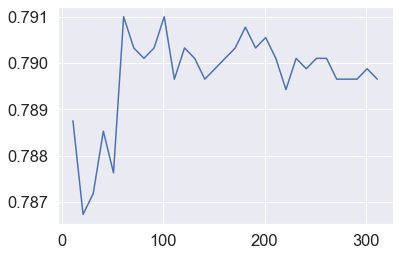

In [82]:
plt.plot(tree_acc['tree'], tree_acc['score'])


С 101 дерева точность меняется не так сильно, следует 110 - опитмальное кол-во деревьев

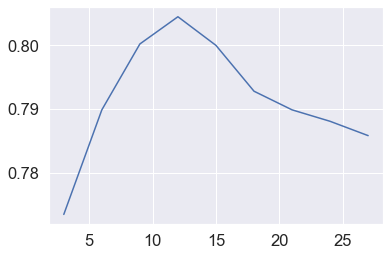

In [83]:
max_depth_grid = [i for i in range(3, 30, 3)]

tree_acc  = pd.DataFrame(columns=['depth', 'score'])
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=110, random_state=42, n_jobs=-1, oob_score=True, max_depth=max_depth)
    rfc.fit(X_train, y_train)
    rfc.score(X_test, y_test)
    tree_acc  = tree_acc .append({'depth': max_depth, 'score': rfc.score(X_test, y_test)}, ignore_index=True)
    
plt.plot(tree_acc ['depth'], tree_acc ['score'])

Максимальная точность при значении глубины = 12, далее точноть понижается

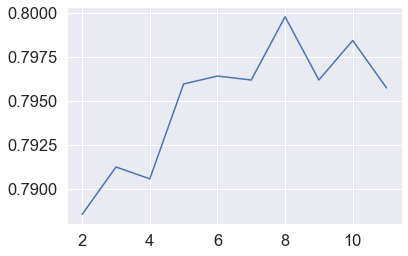

In [84]:
min_samples_split_grid = [i for i in range(2, 12, 1)]

tree_acc = pd.DataFrame(columns=['samples_split', 'score'])
for min_samples_split in min_samples_split_grid:
    rfc = RandomForestClassifier(n_estimators=110, random_state=42, n_jobs=-1, oob_score=True, min_samples_split=min_samples_split)
    rfc.fit(X_train, y_train)
    rfc.score(X_test, y_test)
    tree_acc = tree_acc.append({'samples_split': min_samples_split, 'score': rfc.score(X_test, y_test)}, ignore_index=True)
    
plt.plot(tree_acc['samples_split'], tree_acc['score'])

In [85]:
Наибольшая точность достигается при кол-ве разбиений равным 8

Применим полученные результаты

SyntaxError: invalid syntax (<ipython-input-85-20760763cef7>, line 1)

In [ ]:
rfc = RandomForestClassifier(n_estimators=110, random_state=42, n_jobs=-1, oob_score=True, min_samples_split=8, max_depth = 7)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

In [ ]:
models = []
models.append(DecisionTreeClassifier(max_depth=4, criterion='entropy'))
models.append(DecisionTreeClassifier(max_depth=4, criterion='gini'))
models.append(RandomForestClassifier(n_estimators=110, random_state=42, n_jobs=-1, oob_score=True, min_samples_split=8, max_depth = 7,
                           criterion='entropy'))
models.append(RandomForestClassifier(n_estimators=110, random_state=42, n_jobs=-1, oob_score=True, min_samples_split=8, max_depth = 7,
                           criterion='gini'))
models.append(BaggingClassifier(n_estimators=302, bootstrap=True, random_state=4,))
models.append(GradientBoostingClassifier())
models.append(LinearDiscriminantAnalysis())
models.append(LogisticRegression())

No handles with labels found to put in legend.


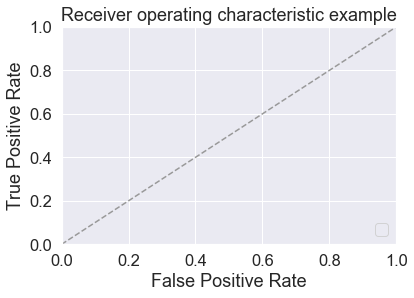

In [70]:
plt.figure(figsize=(15, 15)) 
for model in models:
    model.fit(X_train, y_train)
    
 # оцениваем точность модели
    current_score = model.score(X_test, y_test)

#оцениваем кросс валидацию
    kfold = KFold(n_splits=10, shuffle=True, random_state=7)
    cv_result = max(cross_val_score(model, X_train, y_train, cv=kfold))
 
 #генерируем предсказания
    pred_scr = model.predict_proba(X_test)[:, 1]
    
# вычисление среднеквадратичной ошибки
    rmse = np.sqrt(mean_squared_error(y_test, pred_scr))

# вычисление коэффициента детерминизации
    r2 = r2_score(y_test, pred_scr)
    
# вычисляем площадь под ROC-кривой   
    roc_auc = roc_auc_score(y_test, pred_scr)
    
    md = str(model)
    md = md[:md.find('(')]
    
    roc_auc_print = round(roc_auc, 3)
    rmse_print = round(rmse, 3)
    r2_print = round(r2, 3)
    
    fpr, tpr, thresholds = roc_curve(y_test, pred_scr)
    plt.plot(fpr, tpr, label='ROC: {};  {} {};  {} {};  {} {};  {} {}'.format(md, 'Current score', current_score, 'Auc', roc_auc_print, 'Rmse', rmse_print, 'R2',
                                                                     r2_print))
    
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

C:\Users\One\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\One\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\One\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\One\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\One\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\One\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\One\Anaconda3\lib\site-pa

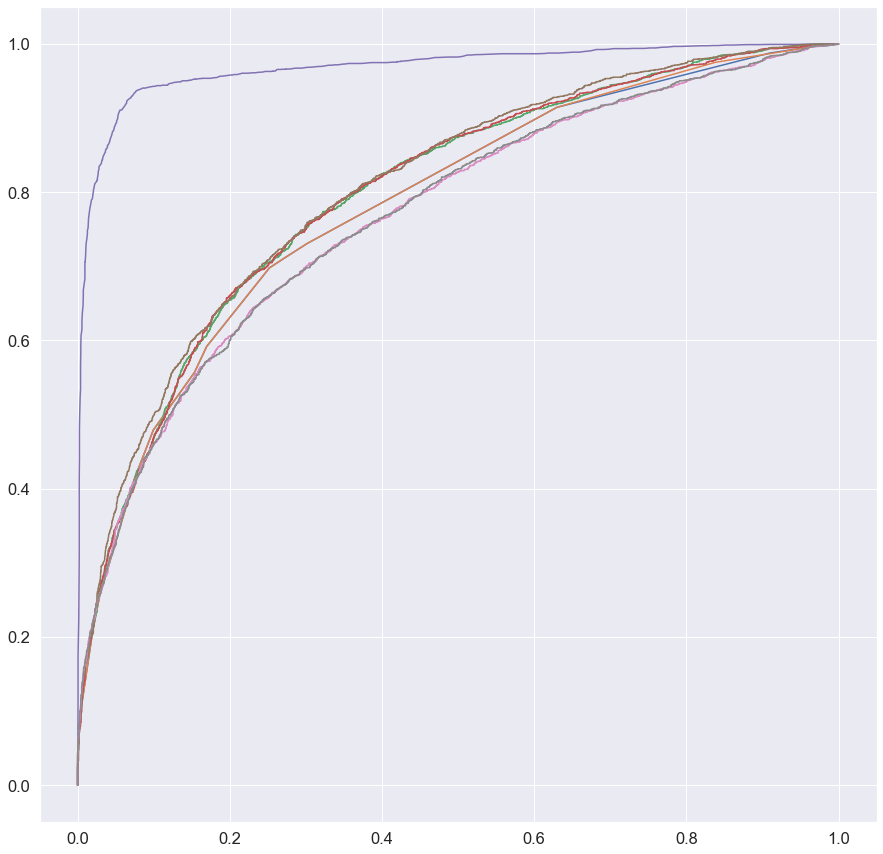

In [75]:
result(X_train, y_train, X_test, y_test)

**Заключение**
    Как мы выдим, лучший результат, по сравнению с другими моделями, показал GradientBoostingClassifier.
    Уровень дохода, возраст и пол клиента больше всего влияют на покупку товара. 
    Предложу сосредоточить свое внимание на группе людей такой категории:
    Уровень дохода (6-11), возраст (41-60), пол (Женщина)
    

Но стоит проверить, сбалансированы ли у нас данные

In [ ]:
print("Число купивших -", len(data4[data4['TargetBuy'] == 1]))
print("Число не купивших -", len(data4[data4['TargetBuy'] == 0]))

sns.set(font_scale=1.5)
count_plt = sns.countplot(x='TargetBuy', data=data4, palette='hls')
plt.show()

Число не купивших товар гораздо больше, чем число купивших. Попробуем сбалансировать выборку и посмотрим на результат

In [ ]:
from imblearn.over_sampling import (RandomOverSampler,
                                    SMOTE,
                                    ADASYN)
from imblearn.under_sampling import NearMiss

In [86]:
#oversampling_df_by_Minority
data_majority = data4[data4['TargetBuy'] == 0]
data_minority = data4[data4['TargetBuy'] == 1]
data_minority_oversampled = resample(data_minority,
                                       replace=True,
                                       n_samples=len(data_majority),
                                       random_state=4
                                       )

data_oversampled = pd.concat([data_majority, data_minority_oversampled])

In [90]:
features = data_oversampled.columns[:-1]
x=data_oversampled[features]
y=data_oversampled.TargetBuy
X_trainOV, X_testOV, y_trainOV, y_testOV = train_test_split(x, y, test_size=0.2, stratify = y, random_state=42)

C:\Users\One\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\One\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\One\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\One\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\One\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\One\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\One\Anaconda3\lib\site-pa

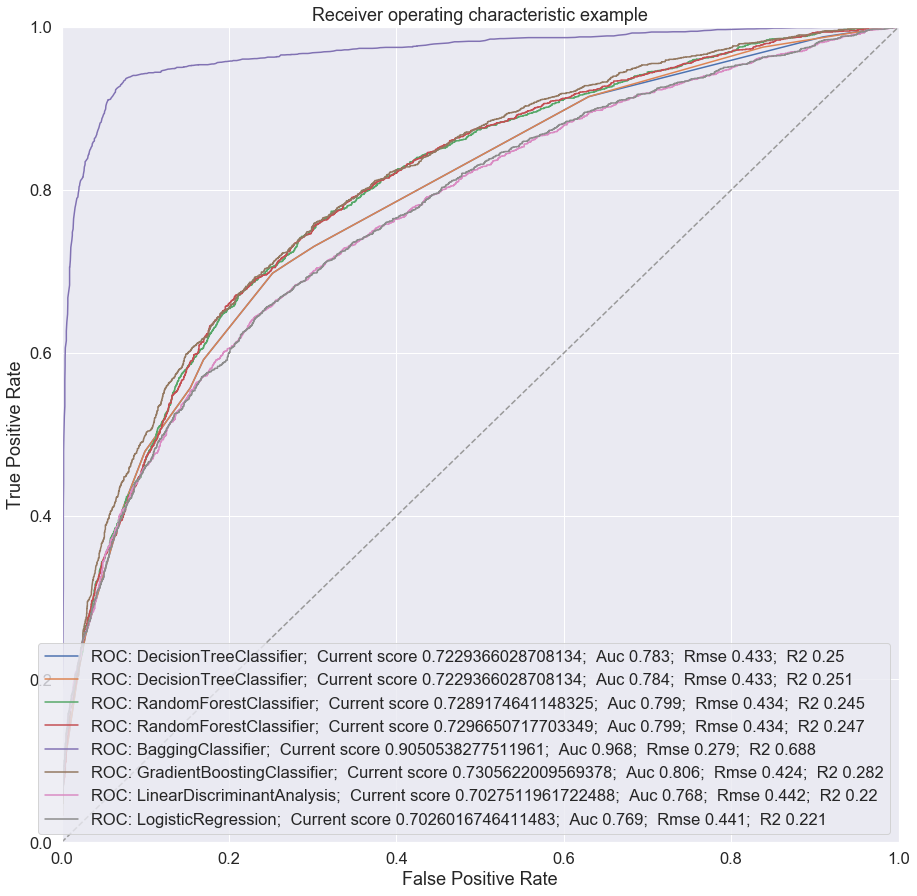

In [91]:
plt.figure(figsize=(15, 15)) 
for model in models:
    model.fit(X_trainOV, y_trainOV)
    current_score = model.score(X_testOV, y_testOV)
    kfold = KFold(n_splits=10, shuffle=True, random_state=7)
    cv_result = max(cross_val_score(model, X_trainOV, y_trainOV, cv=kfold))
    pred_scr = model.predict_proba(X_testOV)[:, 1]
    rmse = np.sqrt(mean_squared_error(y_testOV, pred_scr))
    r2 = r2_score(y_testOV, pred_scr) 
    roc_auc = roc_auc_score(y_testOV, pred_scr)
    
    md = str(model)
    md = md[:md.find('(')]
    
    roc_auc_print = round(roc_auc, 3)
    rmse_print = round(rmse, 3)
    r2_print = round(r2, 3)
    
    fpr, tpr, thresholds = roc_curve(y_testOV, pred_scr)
    plt.plot(fpr, tpr, label='ROC: {};  {} {};  {} {};  {} {};  {} {}'.format(md, 'Current score', current_score, 'Auc', roc_auc_print, 'Rmse', rmse_print, 'R2',
                                                                     r2_print))
    
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()